# Suitability of NDWI for mapping the Sag River flood
In this notebook, we evaluate the (modified) NDWI for the Landsat image of the Sag River flood we are already familiar with.

This notebook recycles many components from our previous NIR thresholding notebook. You can skim it until the NDWI section.

## Getting started

We first need to install and load packages.

Simply click on the little play button in the following code cells. Do not worry about the details.

In [1]:
!pip install ipympl | grep -v 'already satisfied' # for interactive plots

In [2]:
# Setting up packages
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (5,3)

# For interactive plotting
%matplotlib widget
from google.colab import output
output.enable_custom_widget_manager()

path0 = Path('/content/drive/My Drive/Colab Notebooks/') # move this to an Amazon bucket

The image we are about to load comprises the reflectance bands B1 through B7, all scaled to reflectance.


We load the image as a numpy array in the second line


In [3]:
# band names
bands = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7']

# Loads the image into the refl image array; its shape is (7, height, width)
refl = np.load(path0 / 'sagflood.npy')

## Processing the image

To compute the NDWI, we need the Green band B3 (its index is 2 because we start at 0) and the SWIR1 band B6 (index: 5).

We extract these two bands into separate arrays:

In [4]:
# Green image of shape (height, width)
refl_green = refl[2, ...]

# SWIR image of shape (height, width)
refl_swir = refl[5, ...]

To visualize the image using our "natural" false color composite, we extract the corresponding bands. The indices are: 5: SWIR1, 4: NIR, 3: Red.

In [5]:
# RGB image of shape (3, height, width), representing "natural" color composite
refl_natural = refl[(5, 4, 3), ...]

## Visualizing the image

The following two functions are used to visualize the image. The details are not important and go beyond the content of this class, but detailed comments are included if you are interested in learning more.

The first one, *scale_image_percentiles*, takes an RGB image and scales it to the range (0, 1) based on each band's values using percentiles. This is to facilitate visualization.

The second one, *two_panel*, creates an interactive two-panel display.

In [6]:
def scale_image_percentiles(image, p_low=2, p_high=98):
    """
    Scales a 3-band multispectral image to [0, 1] range using adjustable percentiles,
    suitable for display with numpy.imshow.

    Parameters:
        image (numpy.ndarray): A 3D numpy array representing the image,
                               with shape (3, height, width).
        p_low (float): The lower percentile for scaling (default is 2).
        p_high (float): The upper percentile for scaling (default is 98).

    Returns:
        numpy.ndarray: The scaled image with pixel values in the range [0, 1],
                       with shape (3, height, width).
    """
    # Ensure the image is in float format to prevent issues with division
    image = image.astype(np.float32)

    # Calculate the low and high percentiles for each band
    p_low_value = np.percentile(image, p_low, axis=(1, 2), keepdims=True)
    p_high_value = np.percentile(image, p_high, axis=(1, 2), keepdims=True)

    # Scale the image using these percentiles
    scaled_image = (image - p_low_value) / (p_high_value - p_low_value)

    # Clip values to [0, 1] range to handle any values outside this range after scaling
    scaled_image = np.clip(scaled_image, 0, 1)

    return scaled_image

def two_panel(
      image, rgb_image, p_low=2, p_high=98, label='Custom image', scale_image=True):
    """
    Displays a single-band image on the left and an unscaled RGB multispectral image on the right.
    The two axes are linked, and a static grid is added.
    Parameters:
        image (numpy.ndarray): A 2D array with shape (height, width) to be displayed on the left.
        rgb_image (numpy.ndarray): A 3D array with shape (3, height, width) representing the multispectral image.
        p_low (float): The lower percentile for scaling the RGB image (default is 2).
        p_high (float): The upper percentile for scaling the RGB image (default is 98).
        label (string): Label for the left panel
        scale_image (boolean): Applyies percentile scaling to image
    """
    # Scale the RGB image using the provided percentiles
    scaled_rgb_image = scale_image_percentiles(rgb_image, p_low=p_low, p_high=p_high)

    # Transpose the scaled image for correct display in matplotlib
    rgb_image = np.transpose(scaled_rgb_image, (1, 2, 0))

    # Create a figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    plt.subplots_adjust(bottom=0.08)

    # Display the custom image on the left
    if scale_image and not np.issubdtype(image.dtype, np.unsignedinteger):
        vmin, vmax = np.percentile(image, p_low), np.percentile(image, p_high)
    elif np.issubdtype(image.dtype, np.unsignedinteger):
        vmin, vmax = 0, 1 # for binary image
    else:
        vmin, vmax = -1, 1
    im = axes[0].imshow(image, cmap='gray', vmin=vmin, vmax=vmax)
    axes[0].set_title(label)
    axes[0].axis('off')  # Hide the axis

    # Display the RGB image on the right
    axes[1].imshow(rgb_image)
    axes[1].set_title('False Color Composite')
    axes[1].axis('off')  # Hide the axis

    # Link the axes
    def link_axes(ax1, ax2):
        """
        Link the x and y limits of two axes.
        """
        def update_xlim(val):
            ax2.set_xlim(ax1.get_xlim())
            fig.canvas.draw_idle()
        def update_ylim(val):
            ax2.set_ylim(ax1.get_ylim())
            fig.canvas.draw_idle()
        ax1.callbacks.connect('xlim_changed', update_xlim)
        ax1.callbacks.connect('ylim_changed', update_ylim)

    link_axes(axes[0], axes[1])

    # Add a static grid

    def add_static_grid(ax, n_lines=10):
        """
        Add a static grid to the given axis that does not change with zooming.

        Parameters:
            ax (matplotlib.axes.Axes): The axis to which the grid will be added.
            n_lines (int): The number of gridlines
        """
        # Set plotting parameters
        kwplot = {'color': '#ffffcc', 'linewidth': 0.7}

        # Get image dimensions
        xlim = (0, image.shape[1])
        ylim = (0, image.shape[0])

        # Create grid lines
        x_ticks = np.linspace(xlim[0], xlim[1], n_lines)
        y_ticks = np.arange(ylim[0], ylim[1], x_ticks[1] - x_ticks[0])

        for x in x_ticks:
            ax.axvline(x=x, **kwplot)

        for y in y_ticks:
            ax.axhline(y=y, **kwplot)

    add_static_grid(axes[0])
    add_static_grid(axes[1])

    # Add a colorbar if image unless image is a uint image
    if not np.issubdtype(image.dtype, np.unsignedinteger):
        cax = fig.add_axes([0.15, 0.05, 0.2, 0.02])
        fig.colorbar(im, cax=cax, orientation='horizontal')

    # Show the figure
    plt.show()

Let's visualize the SWIR image and the natural composite RGB image side by side.

You can navigate by using the zoom and pan options in the left image.

In [7]:
two_panel(refl_swir, refl_natural, label='SWIR reflectance')

Output hidden; open in https://colab.research.google.com to view.

The SWIR reflectance of water is low, but so is that of ice and snow.

## Computing the NDWI

The following code computes the (modified) NDWI in the first line.

The second line addresses the problem that very dark pixels have a reflectance of exactly zero. For a pixel whose green and SWIR1 reflectance is exactly zero, we cannot evaluate the NDWI, as we would divide by zero. Here, we just set them to one, because water pixels may have such zero reflectance values.

The warning we get when executing this code cell is due to the division by zero issue.

In [8]:
# Compute the NDWI
NDWI = (refl_green - refl_swir) / (refl_green + refl_swir)

# Deal with zero values
NDWI[np.logical_or(refl_green <= 0, refl_swir <= 0)] = 1.0

<ipython-input-8-23d37ef89a47>:1: RuntimeWarning: invalid value encountered in divide
  NDWI = (refl_green - refl_swir) / (refl_green + refl_swir)


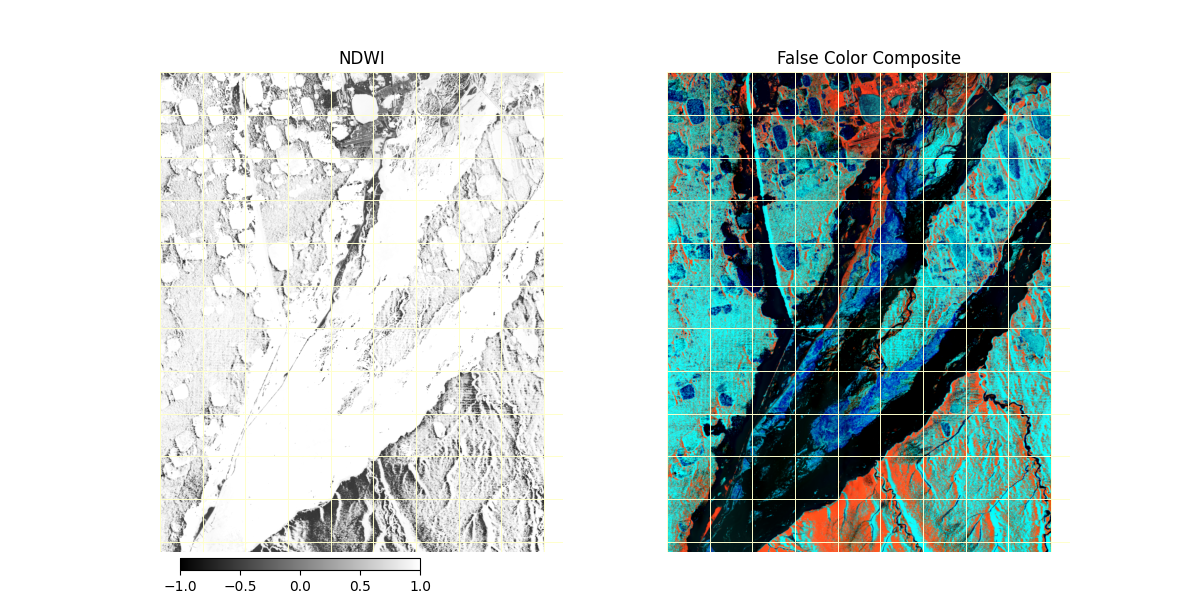

In [9]:
two_panel(NDWI, refl_natural, label='NDWI', scale_image=False)